In [1]:
# CSCI 5352 PS 3 - Predicting missing node labels and edges
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import random

# Import data and create graphs for each 

### Malaria Data ###
G_malaria = nx.read_edgelist("PS3DATA/HVR_5.txt", delimiter=",", nodetype=int)
# add metadata to graph
with open("PS3DATA/metadata_CysPoLV.txt", "r") as file:
    counter = 1
    for line in file:
        attribute = int(line.strip())
        G_malaria.add_node(counter, attr=attribute)
        counter = counter + 1
nodes_malaria = G_malaria.nodes.data()
#print(nodes_malaria)

### Norway Data ###
norway = pd.read_csv("PS3DATA/net1m_2011-08-01.csv/edges.csv")
G_norway = nx.from_pandas_edgelist(norway, source='# source', target=' target')
# add metadata to graph
attr_df = pd.read_csv("PS3DATA/net1m_2011-08-01.csv/nodes.csv", usecols=["# index", " gender"])
for i, row in attr_df.iterrows():
    G_norway.add_node(int(row["# index"]), gender=int(row[" gender"]))

nodes_norway = G_norway.nodes.data()
#print(nodes_norway)

In [2]:
# Problem 1A
from statistics import multimode

# returns graph with (1-alpha) fraction of the attribute removed
def delete_attributes(G, alpha, attribute):
    G_copy = G.copy()
    nodes = list(G_copy.nodes())
    num_to_remove = int(len(nodes) * (1 - alpha))
    nodes_to_delete = random.sample(nodes, num_to_remove)  # Randomly select nodes
    for node in nodes_to_delete:
        if attribute in G_copy.nodes[node]:
            del G_copy.nodes[node][attribute]
    return (G_copy, nodes_to_delete) # return new graph with "unknown" nodes

def smoothing_function(G, unknown_nodes, attribute):
    attributes = [data[attribute] for _, data in G.nodes(data=True) if attribute in data] 
    filled_in_vals = []

    for node in unknown_nodes:
        neighbors = G.neighbors(node)
        attr_lst = []
        exist_neighbor = False
        # compute neighbor mode
        for neighbor in neighbors:
            if attribute in G.nodes[neighbor]:
                attr_lst.append(G.nodes[neighbor][attribute])
                exist_neighbor = True
        if (not exist_neighbor):
            filled_in_vals.append(random.choice(attributes))
        else:
            # random tie break
            mode_val = random.choice(multimode(attr_lst))
            filled_in_vals.append(mode_val)
    return filled_in_vals
    
def get_accuracy(lst1, lst2): # ratio of equal to total entries
    count_equal = sum(1 for a, b in zip(lst1, lst2) if a == b)
    total_entries = len(lst1)
    return count_equal / total_entries


def get_smoothing_accuracy(G, attribute, alpha_range):
    accuracies = []
    iterations = 500
    for alpha in alpha_range:
        # delete random nodes and perform smoothing multiple times to calculate average accuracy:
        avg_accuracy = 0
        for _ in range(iterations):
            (G_new, unknown_nodes) = delete_attributes(G, alpha, attribute)
            actual_vals = [G.nodes[node][attribute] for node in unknown_nodes]
            predicted_vals = smoothing_function(G_new, unknown_nodes, attribute)
            avg_accuracy = avg_accuracy + get_accuracy(actual_vals, predicted_vals)
        accuracies.append(avg_accuracy / iterations)
    return accuracies

In [ ]:
# define alpha
alpha_range = np.arange(0.001, 1, 0.02)

# compute accuracy for each dataset
accuracies_norway = get_smoothing_accuracy(G_norway, "gender", alpha_range)
accuracies_malaria = get_smoothing_accuracy(G_malaria, "attr", alpha_range)

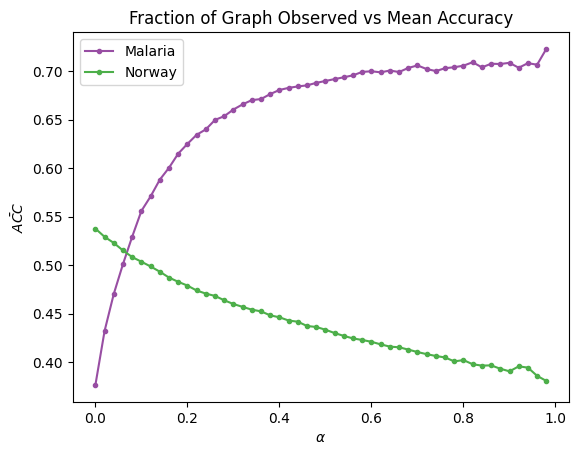

In [ ]:
# Plot comparison of the outputs (alpha vs accuracy)
plt.plot(alpha_range, accuracies_malaria, label='Malaria', marker='.', color = '#984ea3')
plt.plot(alpha_range, accuracies_norway, label='Norway',  marker='.', color = '#4daf4a')
plt.title('Fraction of Graph Observed vs Mean Accuracy')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\bar{ACC}$')
plt.legend()
plt.show()

In [5]:
# calculate expected accuracies:
from collections import Counter

def get_expected_accuracy(G, attribute):
    n = len(G)
    attribute_counts = Counter(nx.get_node_attributes(G, attribute).values())
    node_attribute_sums = {node: attribute_counts[data[attribute]] for node, data in G.nodes(data=True)}
    total_shared = sum(count - 1 for count in node_attribute_sums.values()) # node_attribute_sums contains a node's so subtract one!
    result = total_shared / (n * (n - 1))
    return result

In [6]:
print(f"The malaria dataset has an expected accuracy of: {get_expected_accuracy(G_malaria, 'attr')}")
print(f"The Norway dataset has an expected accuracy of: {get_expected_accuracy(G_norway, 'gender')}")

The malaria dataset has an expected accuracy of: 0.3677162504524068
The Norway dataset has an expected accuracy of: 0.5383096609211921


In [7]:
# Problem 2A
epsilon = 0.001

def JC_score(G, i, j):
    neighbors_i = list(G.neighbors(i))
    neighbors_j = list(G.neighbors(j))
    # if neither node has any neighbors, just apply random noise:
    if(not neighbors_i and not neighbors_j):
        return np.random.uniform(0, epsilon)
    intersection_size = len(set(neighbors_i) & set(neighbors_j))
    union_size = len(set(neighbors_i) | set(neighbors_j))
    return (intersection_size / union_size) + np.random.uniform(0, epsilon)

def DP_score(G, i, j):
    degree_i = G.degree[i]
    degree_j = G.degree[j]
    return degree_i * degree_j + np.random.uniform(0, epsilon)

def SP_score(G, i, j):
    try:
        return (1 / nx.shortest_path_length(G, i, j)) +  np.random.uniform(0, epsilon)
    except nx.NetworkXNoPath:
        # networkx throws exception if there is no path, i.e. length is inf
        return np.random.uniform(0, epsilon)
    
# generate score table for each score, given the list of missing edges and their tau values (1 if the edge actually exists, 0 o.w.)
def generate_table(G, edges, taus):
    DP_scores = np.array([DP_score(G, i, j) for (i, j) in edges])
    SP_scores = np.array([SP_score(G, i, j) for (i, j) in edges])
    JC_scores = np.array([JC_score(G, i, j) for (i, j) in edges])

    # Create table with each score
    edge_array = np.array([(edge, dp, sp, jc, taus) 
                       for edge, dp, sp, jc, taus in zip(edges, DP_scores, SP_scores, JC_scores, taus)], 
                      dtype=[('edge', tuple), ('dp', float), ('sp', float), ('jc', float), ('tau', int)])
    return edge_array

# score_string is either 'jc', 'sp', or 'dp'
# taus is an array of 1, 0 values indicating if the i-th edge exists or not
def calculate_AUC(table, score_string):
    Y = table.shape[0]
    # true positive count:
    T = np.sum(table['tau'])
    F = Y - T

    # sort by score passed in, in descending order:
    sorted_table = np.sort(table, order=score_string)[::-1]
    
    # calculate FPR and TPR for each l:
    tpr_array = (1/T) * np.cumsum(sorted_table['tau'])
    inverse_tau = 1 - sorted_table['tau']
    fpr_array = (1/F) * np.cumsum(inverse_tau)

    # calculate AUC using discrete integration:
    FPR_prev = 0
    discrete_integral = 0
    for l in range(Y):
        TPR_l = tpr_array[l]
        FPR_l = fpr_array[l]
        FPR_diff = FPR_l - FPR_prev
        discrete_integral += TPR_l * FPR_diff
            # Update FPR_prev for the next iteration
        FPR_prev = FPR_l

    # just return TPR and FPR for best case:
    return (discrete_integral, tpr_array, fpr_array)

In [8]:
import itertools

def generate_missing_edges(G, f):
    G_copy = G.copy()
    nodes = list(G_copy.nodes())
    edges = list(G_copy.edges())
    # Get all possible edges in the complete graph (without self-loops)
    all_possible_edges = set((u, v) for u, v in itertools.combinations(nodes, 2))

    # Y: list of unobserved edges in graph
    non_existent_edges = list(all_possible_edges - set(G_copy.edges()))
    
    num_to_remove = int(G_copy.number_of_edges() * (1 - f))
    # randomly sample number of nodes' attributes to remove:
    edges_to_delete = random.sample(edges, num_to_remove)  # Randomly select nodes
    edges_list = edges_to_delete + non_existent_edges
    taus = []
    # Assign 0 to non-existent edges
    taus.extend([1 for u, v in edges_to_delete])
    taus.extend([0 for u, v in non_existent_edges])

    # delete edges from G_copy:
    G_copy.remove_edges_from(edges_to_delete)
    return (G_copy, edges_list, taus)

def get_score_accuracies(G, f_range,iterations=10):
    auc_jc_lst = []
    auc_sp_lst = []
    auc_dp_lst = []
    for f in f_range:
        avg_auc_jc = 0
        avg_auc_sp = 0
        avg_auc_dp = 0
        # calculate average AUC:
        for _ in range(iterations):
            (G_new, edges_list, taus) = generate_missing_edges(G, f)
            table = generate_table(G_new, edges_list, taus)
            auc_jc = calculate_AUC(table, 'jc')[0]
            auc_sp = calculate_AUC(table, 'sp')[0]
            auc_dp = calculate_AUC(table, 'dp')[0]
            avg_auc_jc = avg_auc_jc + auc_jc
            avg_auc_sp = avg_auc_sp + auc_sp
            avg_auc_dp = avg_auc_dp + auc_dp

        auc_jc_lst.append(avg_auc_jc / iterations)
        auc_sp_lst.append(avg_auc_sp / iterations)
        auc_dp_lst.append(avg_auc_dp / iterations)
    return (auc_jc_lst, auc_sp_lst, auc_dp_lst)

# get FPR and TPR for a fixed f value:
def get_fpr_tpr(G, f, iterations=10):
    tpr_fpr_jc = []
    tpr_fpr_sp = []
    tpr_fpr_dp = []
    # calculate average FPR, TPR:
    for _ in range(iterations):
        (G_new, edges_list, taus) = generate_missing_edges(G, f)
        table = generate_table(G_new, edges_list, taus)
        tpr_fpr_jc.append(calculate_AUC(table, 'jc')[1:])
        tpr_fpr_sp.append(calculate_AUC(table, 'sp')[1:])
        tpr_fpr_dp.append(calculate_AUC(table, 'dp')[1:])
    
    return (np.mean(tpr_fpr_jc, axis=0), np.mean(tpr_fpr_sp, axis=0), np.mean(tpr_fpr_dp, axis=0))

In [19]:
def plot_AUC(f_range, jc, sp, dp, title, filesave):
    plt.plot(f_range, jc, label='Jaccard', marker='.', color = '#dede00')
    plt.plot(f_range, sp, label='Shortest Path', marker='.', color = '#e41a1c')
    plt.plot(f_range, dp, label='Degree Product', marker='.', color = '#377eb8')
    plt.plot(f_range, baseline, color = 'black')
    #plt.title('Fraction of Known Edges vs. Accuracy')
    plt.xlabel('f')
    plt.ylabel('AUC')
    plt.legend()
    plt.title(title)
    plt.show()

In [11]:
f_range = np.arange(0.05, 1, 0.05)
(jc_malaria, sp_malaria, dp_malaria) = get_score_accuracies(G_malaria, f_range)
(jc_norway, sp_norway, dp_norway) = get_score_accuracies(G_norway, f_range)

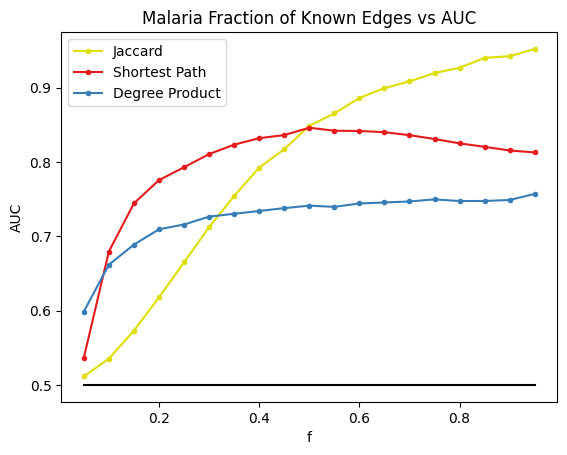

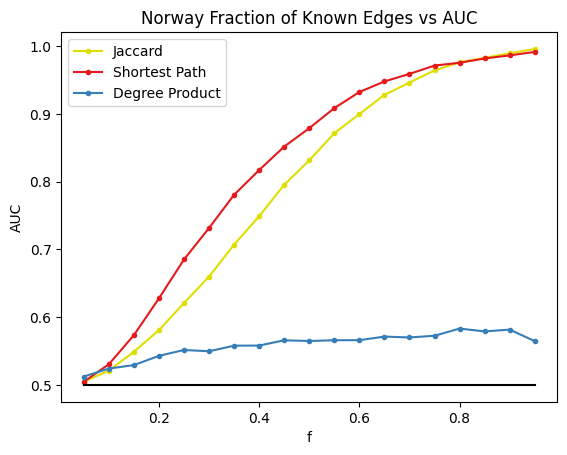

In [20]:
baseline = np.repeat(0.5,19)
plot_AUC(f_range, jc_malaria, sp_malaria, dp_malaria, 'Malaria Fraction of Known Edges vs AUC', 'problem2MAL.pdf')
plot_AUC(f_range, jc_norway, sp_norway, dp_norway, 'Norway Fraction of Known Edges vs AUC', 'problem2NOR.pdf')

In [17]:
# generate ROC plot for f = 0.8
f = 0.8
(tpr_fpr_jc, tpr_fpr_sp, tpr_fpr_dp) = get_fpr_tpr(G_malaria, f)

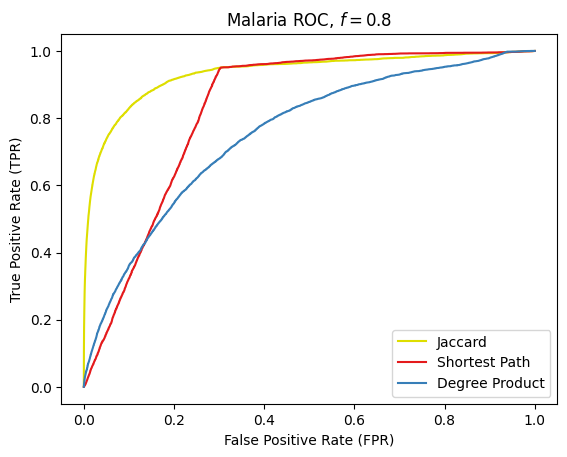

In [18]:
# plot TPR vs FPR array:
plt.plot(tpr_fpr_jc[1], tpr_fpr_jc[0], label='Jaccard', color = '#dede00')
plt.plot(tpr_fpr_sp[1], tpr_fpr_sp[0], label='Shortest Path', color = '#e41a1c')
plt.plot(tpr_fpr_dp[1], tpr_fpr_dp[0], label='Degree Product', color = '#377eb8')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.title("Malaria ROC, $f=0.8$")
plt.savefig("roc-curve.pdf")
plt.show()